## Portfolio Allocation - Stochastic Volatility

In [1]:
ILLUS_PATH <- 'D:/Softwares/GitHub/Discrete-SV-Models-Estimation/Code/Illustration'

In [2]:
library(ggplot2)
library(dplyr)
library(tidyquant)
library(stats)
library(tibble)
library(base)
library(tidyverse)
library(reshape2)
library(pbivnorm)
library(MASS)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyquant' was built under R version 4.1.3"
Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Warning message:
"package 'PerformanceAnalytics' was built under R version 4.1.3"
Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend


Loading required package: quantmod

Loadi

#### 0) Model

In [3]:
sv_simul_can <- function(theta, log_h0){
    epsilon <- c()
    log_h <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    eta <- rnorm(T, 0, 1)
    nu <- rnorm(T, 0, 1)
    
    log_h[1] <- omega + beta * log_h0 + sigma * nu[1]
    epsilon[1] <- sqrt(exp(log_h[1])) * eta[1]
    
    for (t in 2:T){
        log_h[t] <- omega + beta * log_h[t-1] + sigma * nu[t]
        epsilon[t] <- sqrt(exp(log_h[t])) * eta[t]
    }
    list(epsilon, log_h)
}

In [4]:
# Inputs
# omega <- -0.736
# beta <- 0.9
# sigma <- 0.363

omega <- 0
beta <- 0.99
sigma <- 0.2

theta <- c(omega, beta, sigma)
log_h0 <- omega
T <- 2000

In [5]:
set.seed(123)
data <- sv_simul_can(theta, log_h0)
epsilon <- unlist(data[1])
log_h <- unlist(data[2])

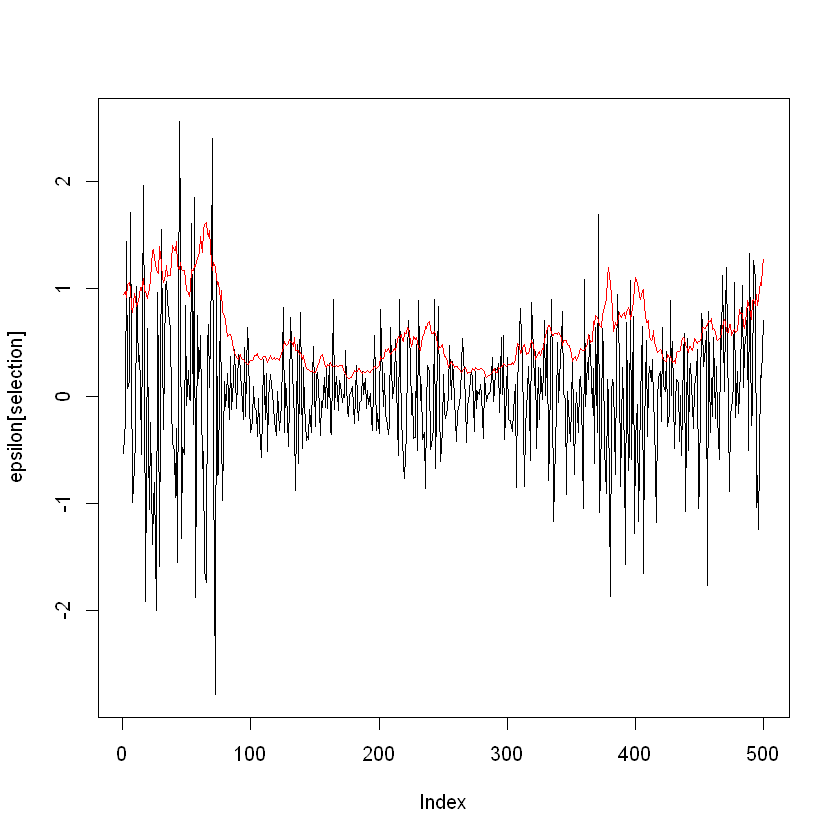

In [6]:
selection <- 1:500
plot(epsilon[selection], type='l', col='black')
lines(sqrt(exp(log_h))[selection], type='l', col='red')

In [7]:
# Input
n <- 500
selection <- 1:n

# Load Data
t<-1:n
col_names<-c('t', 'returns', 'volatility')
confidence_tab <- as.data.frame(epsilon[selection])
confidence_tab <- cbind(confidence_tab, sqrt(exp(log_h))[selection])
confidence_tab <- cbind(t, confidence_tab)
colnames(confidence_tab) <- col_names
confidence_tab <- melt(confidence_tab, id="t")

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart <-ggplot(data=confidence_tab, aes(x=t, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue'),
                       labels = c('Returns', 'Volatility', 'Estimated Volatility'))+
    labs(title = "Returns vs. Stochastic Volatility"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

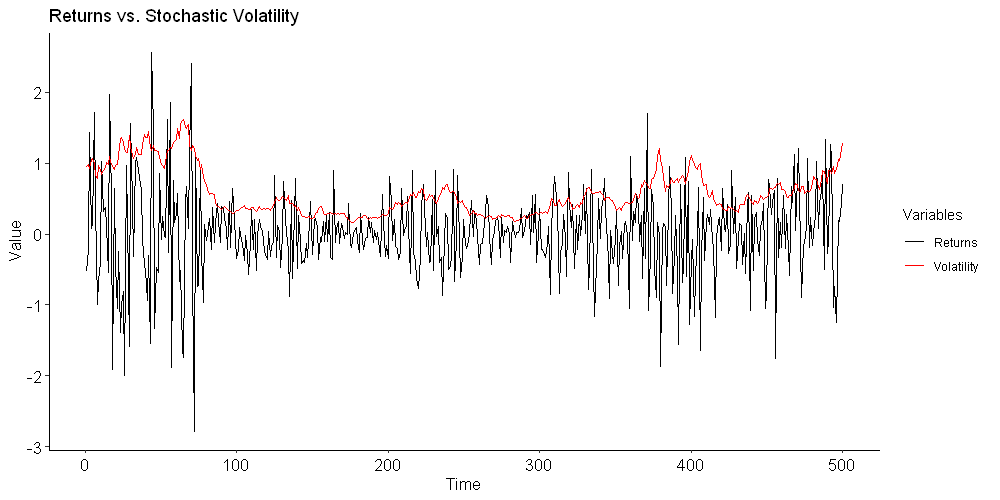

In [9]:
confidence_chart

In [10]:
# pdf(file=paste0(ILLUS_PATH, ".pdf"),width=10, height=5)
# confidence_chart
# dev.off()

#### I) QML Method

In [11]:
obj_sv <- function(theta, epsilon){
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    T <- length(epsilon)
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (t in 2:T){
        F_t[t-1] <- P_t[t-1] + sigma_Z**2
        K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
        alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
        P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
    }
    F_t[T] <- P_t[T-1] + sigma_Z**2
    qml <- -T/2 * log(2*pi) - 1/2*sum(log(F_t) +
        (log(epsilon**2) - alpha_t - mu_Z)**2 / F_t)
    -qml
}

In [12]:
estim_sv <- function(theta0, epsilon){
    valinit <- theta0
    lower <- c(-Inf, 0, 0)
    upper <- c(Inf, 0.999, Inf)
    res <- nlminb(valinit, obj_sv, lower=lower,
                  upper=upper, epsilon=epsilon)
    theta_hat <- res$par[1:3]
    theta_hat
}

In [13]:
# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

In [14]:
estimation <- estim_sv(theta0, epsilon)
theta_hat <- estimation
theta_hat

[1] -0.004512162  0.985746469  0.242665709

In [15]:
alpha_t <- c()
P_t <- c()
F_t <- c()
K_t <- c()
omega <- theta_hat[1]
beta <- theta_hat[2]
sigma <- theta_hat[3]
mu_Z <- -1.270
sigma_Z <- sqrt(pi**2/2)
    
a0 <- 0
beta0 <- 0.8
P0 <- sigma**2
F0 <- P0 + sigma_Z**2
    
T <- length(epsilon)
y_t <- log(epsilon**2)
    
alpha_t[1] <- beta0 * a0 + omega
P_t[1] <- beta**2 * P0 + sigma**2
K_t[1] <- beta * P0 * 1/F0
    
for (t in 2:T){
    F_t[t-1] <- P_t[t-1] + sigma_Z**2
    K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
    alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
    P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
}

In [16]:
# Input
n <- 500
selection <- 1:n

# Load Data
t<-1:n
col_names<-c('t', 'returns', 'volatility')
confidence_tab <- as.data.frame(epsilon[selection])
confidence_tab <- cbind(confidence_tab, sqrt(exp(log_h))[selection])
confidence_tab <- cbind(confidence_tab, sqrt(exp(alpha_t))[selection])
confidence_tab <- cbind(t, confidence_tab)
colnames(confidence_tab) <- col_names
confidence_tab <- melt(confidence_tab, id="t")

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart <-ggplot(data=confidence_tab, aes(x=t, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue'),
                       labels = c('Returns', 'Volatility', 'Estimated Volatility'))+
    labs(title = "Returns vs. Stochastic Volatility"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

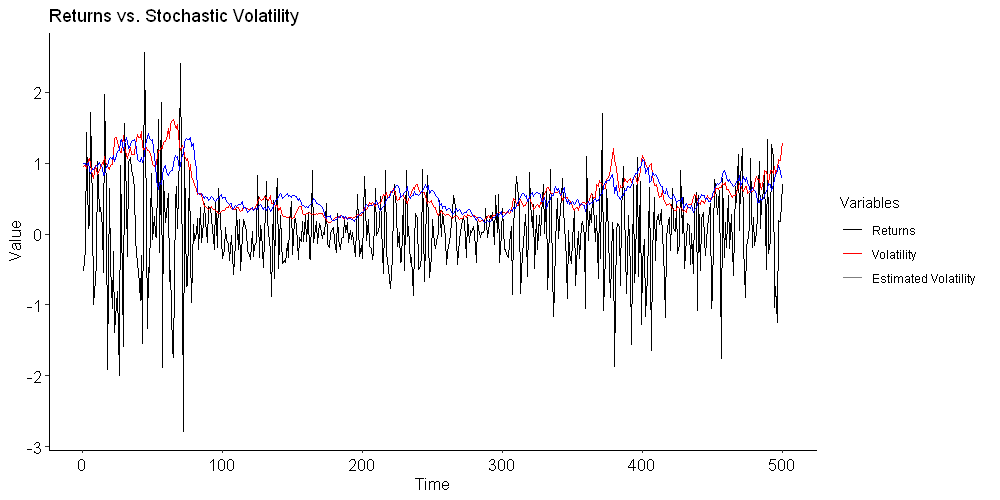

In [18]:
confidence_chart

In [21]:
# pdf(file=paste0(ILLUS_PATH, "QML.pdf"),width=10, height=5)
# confidence_chart
# dev.off()

### Risk

In [32]:
alpha1 <- 0.05
eta_hat <- epsilon / sqrt(exp(alpha_t))
xi_hat <- quantile(eta_hat, probs = seq(0, 1, 0.01))[alpha1*100+1]
VaR <- sqrt(exp(alpha_t)) * xi_hat

In [33]:
# Input
n <- 500
selection <- 1:n

# Load Data
t<-1:n
col_names<-c('t', 'returns', 'VaR')
confidence_tab_var <- as.data.frame(epsilon[selection])
confidence_tab_var <- cbind(confidence_tab_var, VaR[selection])
confidence_tab_var <- cbind(t, confidence_tab_var)
colnames(confidence_tab_var) <- col_names
confidence_tab_var <- melt(confidence_tab_var, id="t")

In [34]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_var <-ggplot(data=confidence_tab_var, aes(x=t, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue'),
                       labels = c('Returns', 'VaR'))+
    labs(title = "Returns vs. VaR"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

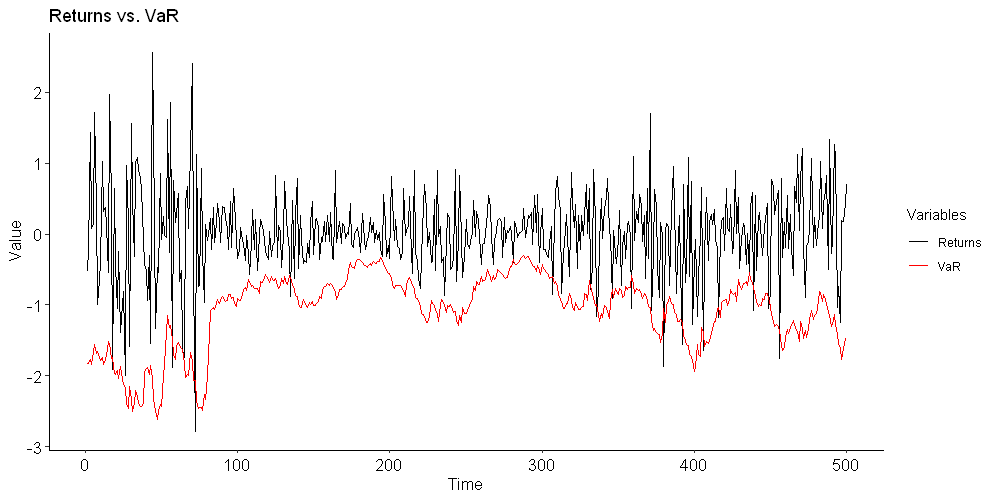

In [35]:
confidence_chart_var